In [1]:
import numpy as np 
import os
import cv2
import sys
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.utils as image

In [2]:
file_path = "test.zip"
output = file_path
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [4]:
#Load the Model
file_path = "test.zip"
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
gender_model = keras.models.load_model('Gender Model/')

#Load the Model
file_path = "test.zip"
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotions_model = keras.models.load_model('Emotions Model/')

In [5]:
import warnings
warnings.filterwarnings("ignore")

def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

def write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict):
    c = 10
    cv2.putText(frame, gender(gender_class_names, gender_classes), (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in sorted_dict.items():    
        cv2.putText(
            frame, 
            str(key) + " " + str(value)[:-5], 
            (x, y-c), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            (36,255,12), 
            2
        )
        c += 30

def gender(gender_class_names, gender_classes):
    return gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]]

def plotChart(sorted_dict, gender, history_data, live):
    global history
    tmp_emotions_class_names = np.insert(emotions_class_names, 6, "")
    tmp_emotions_classes = np.insert(emotions_classes.flatten(), 6, 0)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111, projection='polar')
    ax.set_xticklabels(tmp_emotions_class_names)
    theta = np.arange( 0, 2*np.pi, 2*np.pi/8)
    for key in sorted_dict.keys():
        i = np.where(tmp_emotions_class_names == key)[0][0]
        ax.plot([0, theta[i]], [0, tmp_emotions_classes[i]], 'o-')

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    if live:
        cv2.imshow("chart", img)
        ax.set_visible(False)
        history = np.append(history, {"Gender": gender, **sorted_dict})


1/1 [==============================] - 0s 99ms/step
Woman 'Happy': 0.9999998, 'Disgust': 0.9894922, 'Neutral': 0.85764444


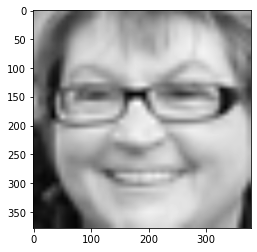

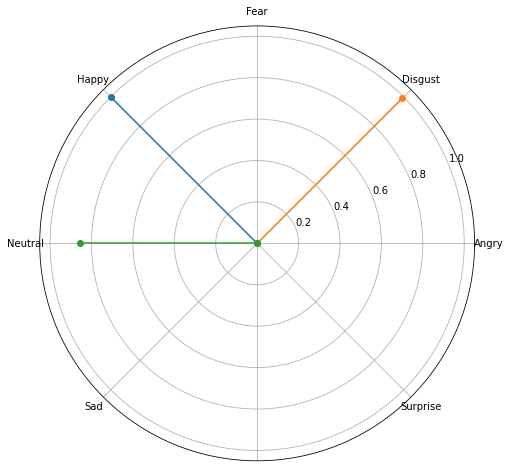

In [6]:
## Load and Predict an image
img = image.load_img("Test Set/100.png", color_mode = "grayscale")

gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
gender_classes = gender_model.predict(prepare_img(gender_img))

emotions_img = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
emotions_classes = emotions_model.predict(prepare_img(emotions_img))

index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])

#print(list((np.argwhere((emotions_classes > 0.8).astype(int).flatten())).flatten()))

dictionary = dict()
sorted_dict = dict()
for i in index:
    dictionary[emotions_class_names[i]] = emotions_classes[0][i]
sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
for w in sorted_keys:
    sorted_dict[w] = dictionary[w]
    
print(gender(gender_class_names, gender_classes) + " " + str(sorted_dict)[1:-1])

plt.imshow(gender_img, cmap="gray")

plotChart(sorted_dict, gender_class_names, False)

1/1 [==============================] - 0s 30ms/step


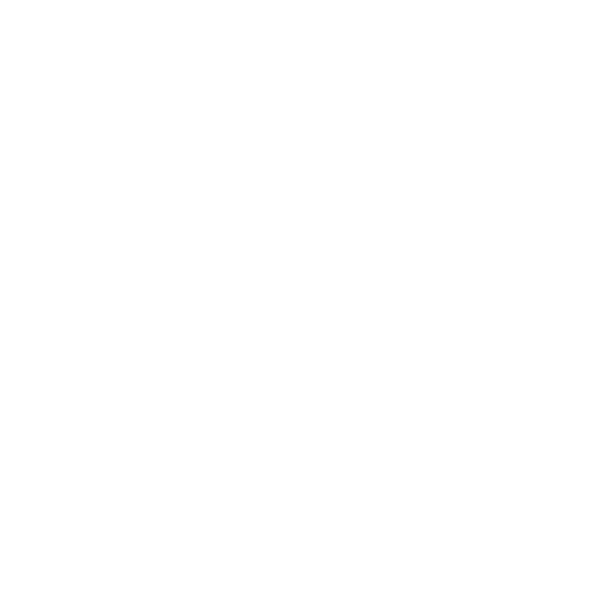

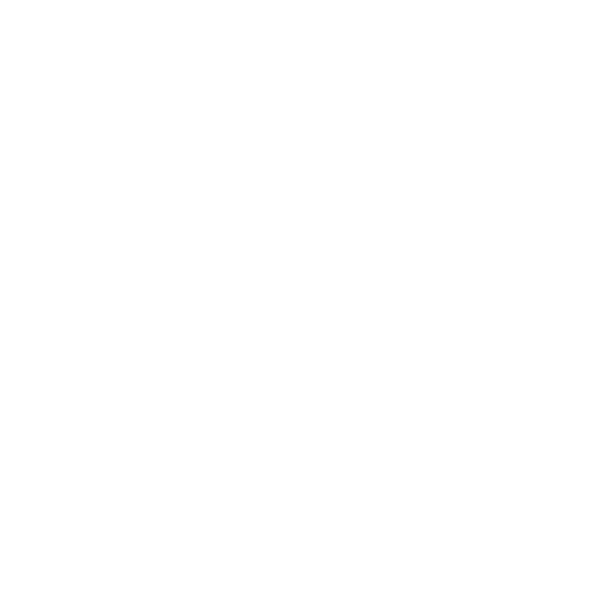

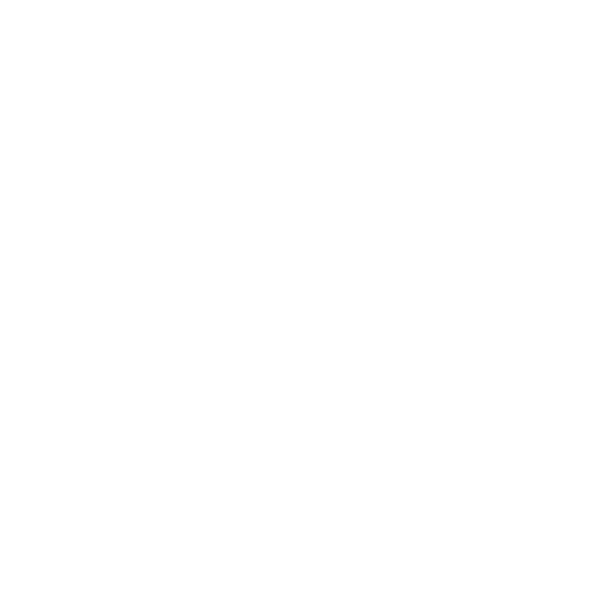

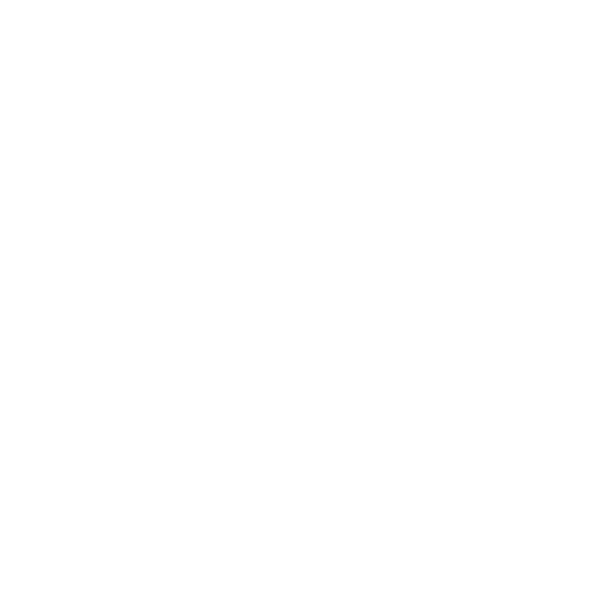

In [7]:
cap = cv2.VideoCapture(0)

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = 30
cur_frames = 0

history = np.array([])

while True:
    ret, frame = cap.read()
    
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        c = 1
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            if process_frame:
                gender_img = cv2.resize(np.float32(gray[y:y+h, x:x+w]), (gender_img_height, gender_img_width))
                gender_classes = gender_model.predict(prepare_img(gender_img))
                resized = cv2.resize(gray[y:y+h, x:x+w], (emotions_img_height,emotions_img_width))
                emotions_classes = emotions_model.predict(prepare_img(resized))
                dictionary = dict()
                sorted_dict = dict()
                index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])
                for i in index:
                    dictionary[emotions_class_names[i]] = emotions_classes[0][i]
                sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
                for w in sorted_keys:
                    sorted_dict[w] = dictionary[w]
                write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict)
                plotChart(sorted_dict, gender(gender_class_names, gender_classes), history, True)
            else:
                write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict)
        cv2.imshow('frame', frame)
        cur_frames += 1
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()


In [71]:
history

array([{'Gender': 'Woman', 'Neutral': 0.9482545, 'Sad': 0.93096495, 'Fear': 0.8120129},
       {'Gender': 'Woman', 'Neutral': 0.9984512, 'Sad': 0.9611998},
       {'Gender': 'Woman', 'Happy': 0.99869895, 'Neutral': 0.97001183},
       {'Gender': 'Woman', 'Happy': 0.9989757, 'Neutral': 0.9730385},
       {'Gender': 'Woman', 'Neutral': 0.98621374, 'Sad': 0.96805245},
       {'Gender': 'Woman', 'Sad': 0.9943473, 'Neutral': 0.9905641, 'Angry': 0.87990654},
       {'Gender': 'Woman', 'Neutral': 0.971672, 'Sad': 0.9545403, 'Angry': 0.9097006},
       {'Gender': 'Woman', 'Neutral': 0.9664477, 'Sad': 0.95170385, 'Angry': 0.9459295}],
      dtype=object)